In [27]:
# ============================================
# STEP 1: DOWNLOAD YOLOv3 FILES
# ============================================
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -q https://pjreddie.com/media/files/yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

In [28]:
# Install OpenCV if not already installed
!pip install opencv-python --quiet

In [29]:
# ============================================
# STEP 2: IMPORT LIBRARIES
# ============================================
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow


In [30]:
# ============================================
# STEP 3: DEFINE A HELPER FUNCTION TO CAPTURE WEBCAM IMAGE
# ============================================
def take_photo(filename='photo.jpg', quality=0.8):
    """
    This function uses JavaScript to access your local webcam
    in the browser, capture one frame, and save it as an image file.
    """
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      // Create a video element
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to ensure it shows the Capture button & video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      const dataURL = canvas.toDataURL('image/jpeg', quality);

      div.remove();
      return dataURL;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [31]:
# ============================================
# STEP 4: LOAD YOLOv3 MODEL
# ============================================
MODEL_CFG = "yolov3.cfg"
MODEL_WEIGHTS = "yolov3.weights"
COCO_NAMES = "coco.names"

# Load class names
with open(COCO_NAMES, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the YOLO network
net = cv2.dnn.readNetFromDarknet(MODEL_CFG, MODEL_WEIGHTS)

# Optional: Switch to CPU explicitly (usually default in Colab)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the output layer names
layer_names = net.getLayerNames()

try:
    # For older 2D format
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except:
    # For newer 1D format
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

print("YOLO model loaded successfully!")
print("Classes loaded:", len(classes), "classes.")

YOLO model loaded successfully!
Classes loaded: 80 classes.


In [32]:
# ============================================
# STEP 5: CAPTURE WEBCAM IMAGE FROM BROWSER
# ============================================
print("Taking photo. Click 'Capture' in the rendered output below.")
image_path = take_photo()

print("Image saved to:", image_path)

Taking photo. Click 'Capture' in the rendered output below.


<IPython.core.display.Javascript object>

Image saved to: photo.jpg


In [33]:
# ============================================
# STEP 6: PERFORM DETECTION ON CAPTURED IMAGE
# ============================================
# Load the captured image using OpenCV
image = cv2.imread(image_path)
(H, W) = image.shape[:2]

# Create a blob from the image
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

layer_outputs = net.forward(output_layers)

boxes = []
confidences = []
class_ids = []

CONF_THRESH = 0.5
NMS_THRESH = 0.3

for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > CONF_THRESH:
            # Scale the bounding box back to the image size
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply Non-Max Suppression to reduce overlapping boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRESH, NMS_THRESH)

Objects detected. Displaying image below:


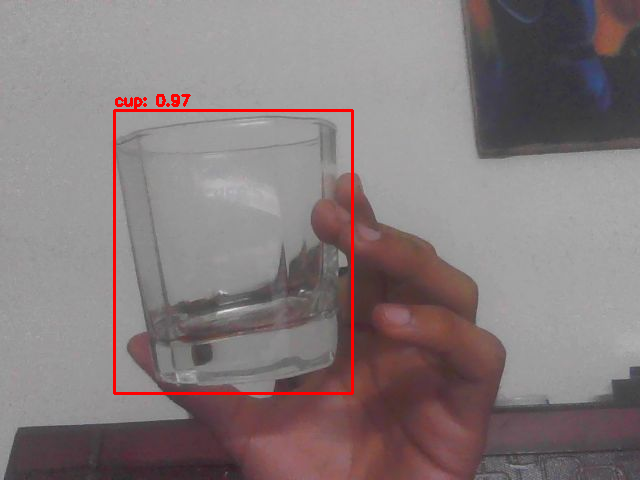

In [34]:
# ============================================
# STEP 7: DRAW THE BOUNDING BOXES & DISPLAY
# ============================================
if len(idxs) > 0:
    for i in idxs.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        conf = confidences[i]

        # Choose a color (just a fixed choice or random) - here we do a simple approach
        color = (0, 255, 0) if label == "person" else (0, 0, 255)

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        # Label text (class name + confidence)
        text = "{}: {:.2f}".format(label, conf)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Show the final image with detections
print("Objects detected. Displaying image below:")
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()